In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('D:/WorkSample/FraudDetetcion/creditcard.csv')

# Step1: Data quality Check and handle imbalance dataset

#### Under-sampling with Logistic Regression, KNN and Random Forest

In [54]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [76]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Text(0, 0.5, 'Amount of data')

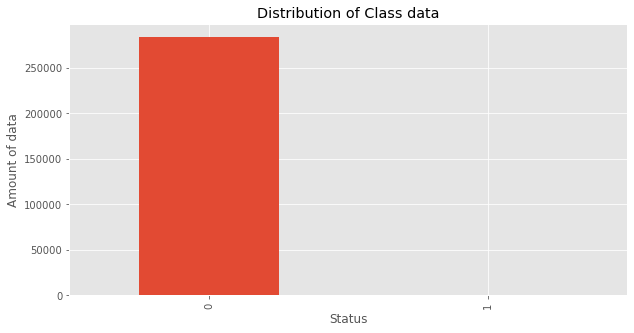

In [56]:
plt.style.use('ggplot')
fig= plt.subplots( 1, 1, figsize= (10, 5))
count_classes = df['Class'].value_counts()
count_classes.plot(kind='bar')
plt.title ("Distribution of Class data")
plt.xlabel ("Status")
plt.ylabel ("Amount of data")

#### Scale Time and Amount

In [77]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

#### Under-sample our dataset

In [78]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
rus_df = normal_distributed_df.sample(frac=1, random_state=42)
rus_df['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

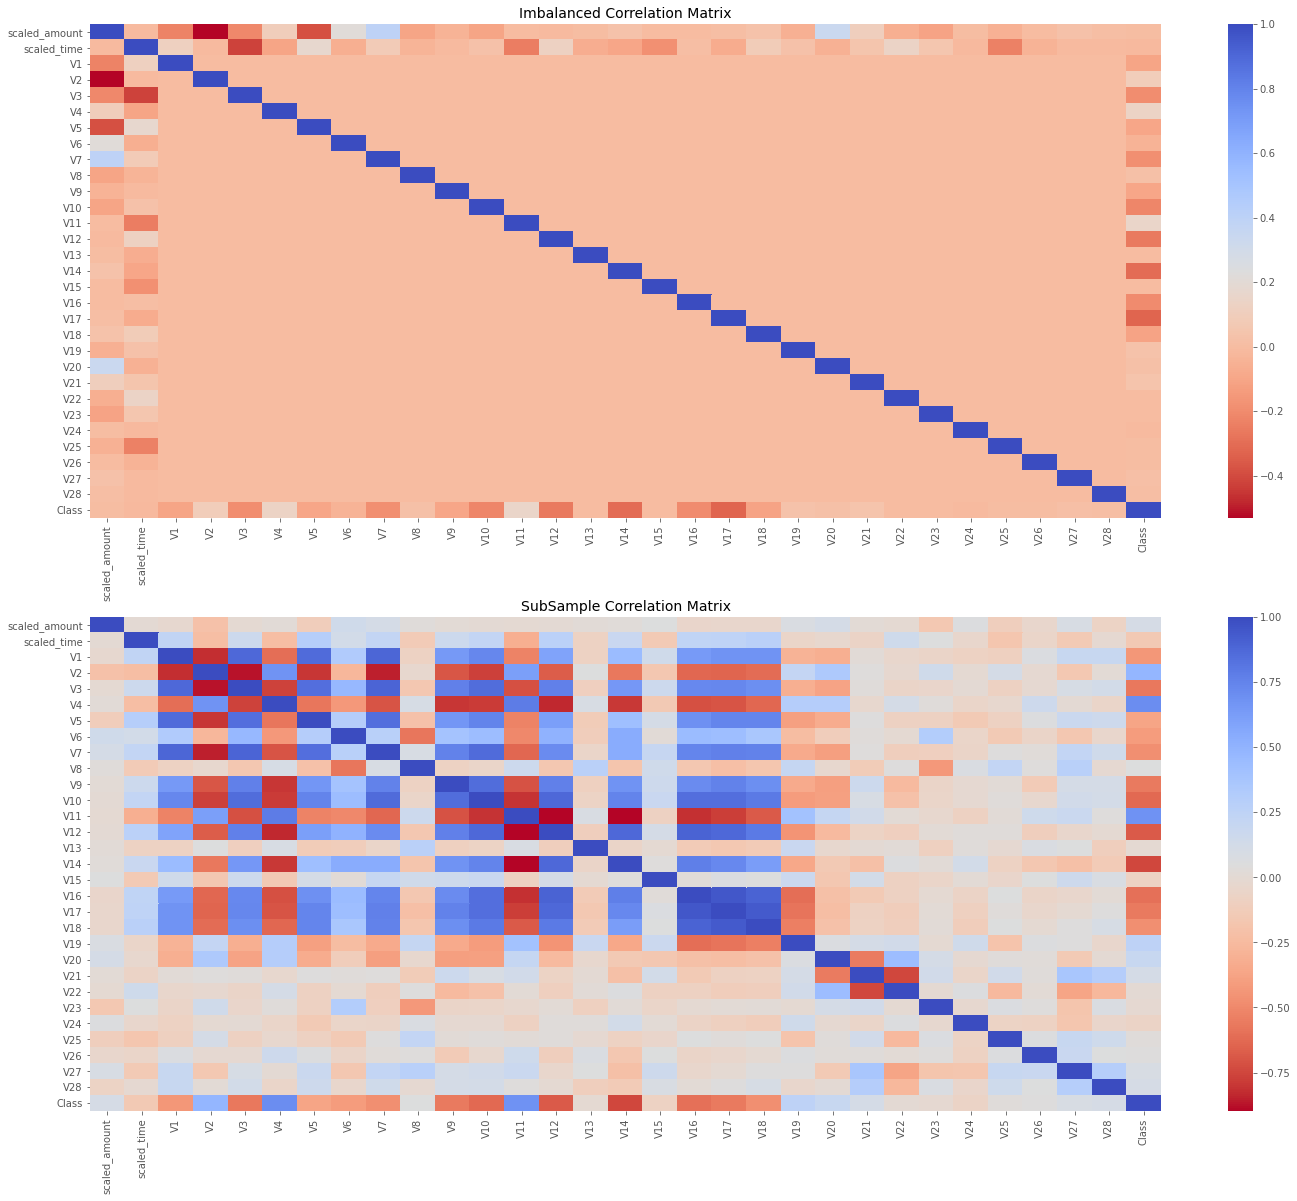

In [59]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = rus_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

You can see that V2, V4, V11, V19 are positively correlated with class. V3, V7, V9, V10, V12, V14, V16, V17 are negatively correlated with class. 

# Step 2: Classifiers with under-sampled dataset

#### Feed dataset to classifiers

In [87]:
X = rus_df.drop('Class', axis=1)
y = rus_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Logistic Regression

In [88]:
lr = LogisticRegression(penalty='l2', class_weight = {1:4,0:1}, C=0.01 , max_iter=200, random_state=15)
lr.fit(X_train, y_train)
lr_pred_rus = lr.predict(X_test)

rus_lr_recall = recall_score(y_test, lr_pred_rus)
rus_lr_precision = precision_score(y_test, lr_pred_rus)
rus_lr_accuracy = accuracy_score(y_test, lr_pred_rus)
rus_lr_f1 = f1_score(y_test, lr_pred_rus)
rus_lr_auc = roc_auc_score(y_test, lr_pred_rus)

print(f'For the Logistic Regression, we got:')
print(f'recall: {rus_lr_recall}')
print(f'precison: {rus_lr_precision}')
print(f'accuracy: {rus_lr_accuracy}')
print(f'F1-Score: {rus_lr_f1}')
print(f'AUC-Score: {rus_lr_auc}')

For the Logistic Regression, we got:
recall: 0.9197530864197531
precison: 0.93125
accuracy: 0.918918918918919
F1-Score: 0.9254658385093167
AUC-Score: 0.9188317670904735


In [89]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.988654 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


#### KNN

In [ ]:
knn_params = {
    "n_neighbors":range(1,30,2),
    "weights":["uniform", "distance"],
    "metric":["euclidean", "manhattan", "minkowski"],
    "leaf_size":range(1,50,5)
}

knn  = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, n_jobs=1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

final_knn = knn.set_params(**grid_result.best_params_)
final_knn.fit(X_train, y_train)
y_pred  = final_knn.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
pring(grid_results.best_params_)

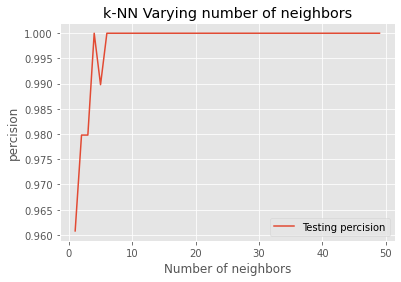

Wall time: 1.35 s


In [35]:
%%time
neighbors = np.arange(1,50)
test_percision = np.empty(len(neighbors))

plt.style.use('ggplot')

for i,k in enumerate(neighbors):
    rus_knn = KNeighborsClassifier(n_neighbors=k)
    rus_knn.fit(X_train, y_train)
    y_pred_knn = rus_knn.predict(X_test)
    
    test_percision[i] = precision_score(y_test, y_pred_knn) 
 
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_percision, label='Testing percision')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('percision')
plt.show()

In [52]:
rus_knn = KNeighborsClassifier(n_neighbors=10)
rus_knn.fit(X_train, y_train)
y_pred_knn = rus_knn.predict(X_test)

rus_knn_recall = recall_score(y_test, y_pred_knn)
rus_knn_precision = precision_score(y_test, y_pred_knn)
rus_knn_accuracy = accuracy_score(y_test, y_pred_knn)
rus_knn_f1 = f1_score(y_test, y_pred_knn)

print(f'For the KNN, we got:')
print(f'recall: {rus_knn_recall}')
print(f'precison: {rus_knn_precision}')
print(f'accuracy: {rus_knn_accuracy}')
print(f'F1-Score: {rus_knn_f1}')

For the KNN, we got:
recall: 0.8818181818181818
precison: 0.97
accuracy: 0.9187817258883249
F1-Score: 0.9238095238095237


#### Random Forest

In [39]:
rus_rfc = RandomForestClassifier() 
rus_rfc.fit(X_train, y_train) 
y_pred_rf = rus_rfc.predict(X_test)

rus_rf_recall = recall_score(y_test, y_pred_rf)
rus_rf_precision = precision_score(y_test, y_pred_rf)
rus_rf_accuracy = accuracy_score(y_test, y_pred_rf)
rus_rf_f1 = f1_score(y_test, y_pred_rf)

print(f'For the RF, we got:')
print(f'recall: {rus_rf_recall}')
print(f'precison: {rus_rf_precision}')
print(f'accuracy: {rus_rf_accuracy}')
print(f'F1-Score: {rus_rf_f1}')

For the RF, we got:
recall: 0.8909090909090909
precison: 1.0
accuracy: 0.9390862944162437
F1-Score: 0.9423076923076923


# Step 3: Classifiers with Random Over-sampled dataset

In [40]:
from imblearn.over_sampling import RandomOverSampler

In [41]:
y = df['Class']
x = df.drop(['Class'], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                  test_size=0.25, random_state=44, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [42]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=1)
X_train, y_train = oversample.fit_resample(x_train, y_train)
y_train.value_counts()

0    213236
1    213236
Name: Class, dtype: int64

#### KNN

In [20]:
%%time
neighbors = np.arange(1,100)
test_percision = np.empty(len(neighbors))

plt.style.use('ggplot')

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(x_test)
    
    test_percision[i] = precision_score(y_test, y_pred_knn) 
 
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_percision, label='Testing percision')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('percision')
plt.show()

KeyboardInterrupt: 

#### I ended the cell above cuz it took too long to run :(

In [44]:
knn = KNeighborsClassifier(n_neighbors=5, 
                           weights = "distance")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(x_test)

knn_recall = recall_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f'For the RF, we got:')
print(f'recall: {knn_recall}')
print(f'precison: {knn_precision}')
print(f'accuracy: {knn_accuracy}')
print(f'F1-Score: {knn_f1}')

For the RF, we got:
recall: 0.8211382113821138
precison: 0.7426470588235294
accuracy: 0.9991994606893064
F1-Score: 0.7799227799227799


#### Random Forest

In [45]:
ros_rfc = RandomForestClassifier() 
ros_rfc.fit(X_train, y_train) 
y_pred_ros = ros_rfc.predict(x_test)

rf_recall = recall_score(y_test, y_pred_ros)
rf_precision = precision_score(y_test, y_pred_ros)
rf_accuracy = accuracy_score(y_test, y_pred_ros)
rf_f1 = f1_score(y_test, y_pred_ros)

print(f'For the RF, we got:')
print(f'recall: {rf_recall}')
print(f'precison: {rf_precision}')
print(f'accuracy: {rf_accuracy}')
print(f'F1-Score: {rf_f1}')

For the RF, we got:
recall: 0.7967479674796748
precison: 0.9158878504672897
accuracy: 0.999522485323446
F1-Score: 0.8521739130434782


# Sum up

1. For this project, I used two different methods to handle the imbalanced dataset: Random Undersampling and Oversampling.
2. There is one challenges been met during the whole project:
In the first try with under-sampling, the performance of three classifier is extremely poor. The precision and recall are        all below 0.5. The reason is that the procedure of under-sample was wrong. The correct procedure should be under-sample          the origin dataset first then do the train-test spliting. But I did it in the ooposite way. When I correct the procedure, the precison for all three classifier went over 90%.
3. For the future improvements, I think I can apply more advanced undersampling and oversampling methods, such as SMOTE and NEARMISS. For the model improvement, I think I can also apply unsupervised machine models, such as SVM, into this project. 